# Demo

## Our First Version

In [3]:
import sys
import numpy as np
from itertools import takewhile
import logging
from logbuilder import buildLogger
import cvxpy as cp

def searchOpt(C):
    """
    @C: historical prices with corr high than rho
    """
    numAssets = C.shape[0]
    logger = logging.getLogger('CORN') 
    
    b = cp.Variable(numAssets, pos = True)
    prob = cp.Problem(cp.Minimize(-1 * cp.sum(cp.log(C.T * b))), [cp.sum(b) == 1])
    logger.debug('Solving Problem: ' + str(prob.solve(solver = 'SCS')))
    return np.array(b.value)


class expert():
    def __init__(self, rho, timeWindow, initialWealth = 1):
        """
        initialize:
        @rho: correlation threshold
        @timeWindow: specific time windows
        @initialWealth: wealth
        """
        self.rho =rho
        self.timeWindow = timeWindow
        self.wealth = initialWealth
    def learning(self, Xh):
        """
        @Xh: historical prices until time t, m*(t-1)
        Return:
        @portfolio: array of weights put on each assets
        """
        # Use h instead of t here since h = t-1
        numAssets, h = Xh.shape
        self.portfolio = np.ones(numAssets)/numAssets
        # if have reached w(timeWindow) + 1 days
        if h > self.timeWindow:
            indexSet = [np.corrcoef(Xh[:,-self.timeWindow:].reshape(-1), Xh[:,i-self.timeWindow: i].reshape(-1))[1][0] >= self.rho\
                        for i in range(self.timeWindow ,h)]
            if sum(indexSet) > 0:
                self.portfolio = searchOpt(Xh[:,self.timeWindow:][:,indexSet])
        return self.portfolio
    def update(self, xt):
        """
        Update at the end of the day
        @xt: prices of the current trading day
        """
        self.wealth *= np.sum(self.portfolio * xt)


def preProcess(data_path):
    dataWithWeekend = np.loadtxt(data_path, delimiter=' ')
    # Remove days when market closed
    dataWithoutWeekend = dataWithWeekend[:,dataWithWeekend[0]!= 0]
    # Start Date: the number of zeros before the first non-zero data
    startDate = [len(list(takewhile(i))) for i in dataWithoutWeekend]
    # Transform the data into relative prices compared to the day before
    # Seems that a Numba function @nb.jit could help fill nulls, not used here


def combine(portfolioSet, wealthSet, q):
    """
    Combine the experts' portfolios
    @portfolioSet: array of portfolios, W * m(numAssets)
    @wealthSet: array of experts' current wealth, W
    @q: array of probability distribution function, m
    """
    nome = np.sum(portfolioSet.T * wealthSet * q, axis = 1)
    deno = np.sum(wealthSet * q)
    return nome/deno

def CORNU(rho, W, X):
    """
    main algorithm
    @rho: correlation threshold
    @W: maximum time window length
    @X: historical prices matrix, m(numAssets) * T
    """
    logger = logging.getLogger('CORN')
    # Initialize weights q and wealth
    q = np.ones(W)/W
    numAssets, T = X.shape
    wealth = 1
    wealthRecord = np.ones(T+1)
    portfolioRecord = np.zeros((numAssets,T))
    expertPort = [expert(rho,w) for w in range(1,W+1)]
    numAssets, T = X.shape

    for t in range(T):
        logger.info('Start Day ' + str(t))
        portfolioSet = [expertI.learning(X[:,:t]) for expertI in expertPort]
        wealthSet = [expertI.wealth for expertI in expertPort]
        portfolioOverall = combine(np.array(portfolioSet), np.array(wealthSet), q)
        wealth *= np.sum(portfolioOverall * X[:,t])
        print(wealth)
        for expertI in expertPort:
            expertI.update(X[:,t])
        logger.info('End Day with wealth '+ str(wealth))
        wealthRecord[t] = wealth
        portfolioRecord[:,t] = portfolioOverall
    return wealthRecord, portfolioRecord


2019-04-23 01:38:53,507 Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2019-04-23 01:38:53,515 Starting new HTTPS connection (1): finance.yahoo.com:443
2019-04-23 01:38:54,192 https://finance.yahoo.com:443 "GET /quote/MSFT/history?period1=1104570000&period2=1556092799&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
2019-04-23 01:38:55,205 https://finance.yahoo.com:443 "GET /quote/IBM/history?period1=1104570000&period2=1556092799&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
2019-04-23 01:38:55,835 https://finance.yahoo.com:443 "GET /quote/AAPL/history?period1=1104570000&period2=1556092799&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
2019-04-23 01:38:56,446 https://finance.yahoo.com:443 "GET /quote/GOOG/history?period1=1104570000&period2=1556092799&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
2019-04-23 01:38:56,624 Start Day 0
2019-04-23 01:38:56,626 End Day with wealth 1.0
2019-04-23 01:38:56,626 Start Day 1


1.0
0.9906919248605582
0.990534462625539
0.9849260051035724
1.0274820437799965
1.0254570444603317
1.0046107033744667
1.0104845459094631
1.014355935987743


2019-04-23 01:38:56,894 End Day with wealth 1.0272524240573258
2019-04-23 01:38:56,895 Start Day 10
2019-04-23 01:38:56,934 End Day with wealth 1.0354471341719464
2019-04-23 01:38:56,935 Start Day 11
2019-04-23 01:38:56,967 End Day with wealth 1.0164183781518834
2019-04-23 01:38:56,968 Start Day 12
2019-04-23 01:38:56,995 End Day with wealth 1.0176382228502676
2019-04-23 01:38:56,996 Start Day 13
2019-04-23 01:38:57,044 End Day with wealth 1.011736010038886
2019-04-23 01:38:57,044 Start Day 14


1.0272524240573258
1.0354471341719464
1.0164183781518834
1.0176382228502676
1.011736010038886


2019-04-23 01:38:57,087 End Day with wealth 1.0038586368499962
2019-04-23 01:38:57,088 Start Day 15
2019-04-23 01:38:57,133 End Day with wealth 1.016581952098478
2019-04-23 01:38:57,134 Start Day 16
2019-04-23 01:38:57,186 End Day with wealth 1.022200959276548
2019-04-23 01:38:57,187 Start Day 17
2019-04-23 01:38:57,204 End Day with wealth 1.0236964091266072
2019-04-23 01:38:57,205 Start Day 18
2019-04-23 01:38:57,239 End Day with wealth 1.037976428736997
2019-04-23 01:38:57,240 Start Day 19


1.0038586368499962
1.016581952098478
1.022200959276548
1.0236964091266072
1.037976428736997
1.0681492766085876


2019-04-23 01:38:57,283 End Day with wealth 1.0681492766085876
2019-04-23 01:38:57,284 Start Day 20
2019-04-23 01:38:57,333 End Day with wealth 1.0614438995567617
2019-04-23 01:38:57,333 Start Day 21


1.0614438995567617


2019-04-23 01:38:57,554 End Day with wealth 1.0946789977023283
2019-04-23 01:38:57,555 Start Day 22
2019-04-23 01:38:57,620 End Day with wealth 1.0775176320119078
2019-04-23 01:38:57,621 Start Day 23


1.0946789977023283
1.0775176320119078
1.066667239715588


2019-04-23 01:38:57,750 End Day with wealth 1.066667239715588
2019-04-23 01:38:57,751 Start Day 24
2019-04-23 01:38:57,801 End Day with wealth 1.065392241724373
2019-04-23 01:38:57,802 Start Day 25
2019-04-23 01:38:57,848 End Day with wealth 1.085743195133433
2019-04-23 01:38:57,849 Start Day 26
2019-04-23 01:38:57,923 End Day with wealth 1.0541395588590234
2019-04-23 01:38:57,924 Start Day 27


1.065392241724373
1.085743195133433
1.0541395588590234
1.0431321136859733


2019-04-23 01:38:57,989 End Day with wealth 1.0431321136859733
2019-04-23 01:38:57,990 Start Day 28
2019-04-23 01:38:58,050 End Day with wealth 1.075580520121526
2019-04-23 01:38:58,051 Start Day 29
2019-04-23 01:38:58,123 End Day with wealth 1.1119388032970317
2019-04-23 01:38:58,124 Start Day 30
2019-04-23 01:38:58,195 End Day with wealth 1.1339255935410986
2019-04-23 01:38:58,195 Start Day 31


1.075580520121526
1.1119388032970317
1.1339255935410986


2019-04-23 01:38:58,265 End Day with wealth 1.1486022344252858
2019-04-23 01:38:58,266 Start Day 32
2019-04-23 01:38:58,335 End Day with wealth 1.13446126219621
2019-04-23 01:38:58,336 Start Day 33
2019-04-23 01:38:58,417 End Day with wealth 1.1266741544954293
2019-04-23 01:38:58,417 Start Day 34


1.1486022344252858
1.13446126219621
1.1266741544954293


2019-04-23 01:38:58,491 End Day with wealth 1.1087801165091822
2019-04-23 01:38:58,491 Start Day 35
2019-04-23 01:38:58,563 End Day with wealth 1.1470254681971028
2019-04-23 01:38:58,564 Start Day 36
2019-04-23 01:38:58,641 End Day with wealth 1.148232796927514
2019-04-23 01:38:58,642 Start Day 37


1.1087801165091822
1.1470254681971028
1.148232796927514


2019-04-23 01:38:58,715 End Day with wealth 1.1449282438977777
2019-04-23 01:38:58,716 Start Day 38
2019-04-23 01:38:58,788 End Day with wealth 1.154320043376079
2019-04-23 01:38:58,788 Start Day 39
2019-04-23 01:38:58,860 End Day with wealth 1.1450566126728745
2019-04-23 01:38:58,861 Start Day 40


1.1449282438977777
1.154320043376079
1.1450566126728745


2019-04-23 01:38:58,928 End Day with wealth 1.1370810219315792
2019-04-23 01:38:58,929 Start Day 41
2019-04-23 01:38:58,996 End Day with wealth 1.1047685412556147
2019-04-23 01:38:58,997 Start Day 42
2019-04-23 01:38:59,037 End Day with wealth 1.1060090568341
2019-04-23 01:38:59,038 Start Day 43
2019-04-23 01:38:59,092 End Day with wealth 1.106864262939406
2019-04-23 01:38:59,092 Start Day 44


1.1370810219315792
1.1047685412556147
1.1060090568341
1.106864262939406


2019-04-23 01:38:59,151 End Day with wealth 1.090098250308857
2019-04-23 01:38:59,152 Start Day 45
2019-04-23 01:38:59,305 End Day with wealth 1.0645814160034748
2019-04-23 01:38:59,306 Start Day 46


1.090098250308857
1.0645814160034748


2019-04-23 01:38:59,371 End Day with wealth 1.0757182137246126
2019-04-23 01:38:59,372 Start Day 47
2019-04-23 01:38:59,450 End Day with wealth 1.0784314168444626
2019-04-23 01:38:59,450 Start Day 48
2019-04-23 01:38:59,530 End Day with wealth 1.0797706220656962
2019-04-23 01:38:59,531 Start Day 49


1.0757182137246126
1.0784314168444626
1.0797706220656962


2019-04-23 01:38:59,621 End Day with wealth 1.0969243033291058
2019-04-23 01:38:59,623 Start Day 50
2019-04-23 01:38:59,724 End Day with wealth 1.0906722983579011
2019-04-23 01:38:59,724 Start Day 51


1.0969243033291058
1.0906722983579011


2019-04-23 01:38:59,868 End Day with wealth 1.1091043965798038
2019-04-23 01:38:59,869 Start Day 52
2019-04-23 01:38:59,955 End Day with wealth 1.1202580158046525
2019-04-23 01:38:59,956 Start Day 53
2019-04-23 01:39:00,052 End Day with wealth 1.1270036233460976


1.1091043965798038
1.1202580158046525
1.1270036233460976


2019-04-23 01:39:00,053 Start Day 54
2019-04-23 01:39:00,138 End Day with wealth 1.107878918391088
2019-04-23 01:39:00,139 Start Day 55
2019-04-23 01:39:00,235 End Day with wealth 1.1061929591021347
2019-04-23 01:39:00,236 Start Day 56


1.107878918391088
1.1061929591021347


2019-04-23 01:39:00,474 End Day with wealth 1.1063119062387488
2019-04-23 01:39:00,475 Start Day 57
2019-04-23 01:39:00,556 End Day with wealth 1.1050063917691237
2019-04-23 01:39:00,557 Start Day 58
2019-04-23 01:39:00,639 End Day with wealth 1.091774405184998
2019-04-23 01:39:00,640 Start Day 59


1.1063119062387488
1.1050063917691237
1.091774405184998


2019-04-23 01:39:00,726 End Day with wealth 1.105393838154128
2019-04-23 01:39:00,727 Start Day 60
2019-04-23 01:39:00,818 End Day with wealth 1.0811099328498845
2019-04-23 01:39:00,819 Start Day 61
2019-04-23 01:39:00,892 End Day with wealth 1.0745842436989466
2019-04-23 01:39:00,893 Start Day 62


1.105393838154128
1.0811099328498845
1.0745842436989466


2019-04-23 01:39:00,982 End Day with wealth 1.074763377235632
2019-04-23 01:39:00,983 Start Day 63
2019-04-23 01:39:01,070 End Day with wealth 1.0885949048930328
2019-04-23 01:39:01,071 Start Day 64
2019-04-23 01:39:01,159 End Day with wealth 1.0953379794727678
2019-04-23 01:39:01,160 Start Day 65


1.074763377235632
1.0885949048930328
1.0953379794727678


2019-04-23 01:39:01,247 End Day with wealth 1.1180658484018804
2019-04-23 01:39:01,248 Start Day 66
2019-04-23 01:39:01,405 End Day with wealth 1.117490602130779
2019-04-23 01:39:01,406 Start Day 67


1.1180658484018804
1.117490602130779


2019-04-23 01:39:01,528 End Day with wealth 1.086402289528832
2019-04-23 01:39:01,529 Start Day 68
2019-04-23 01:39:01,619 End Day with wealth 1.0899887663030674
2019-04-23 01:39:01,620 Start Day 69
2019-04-23 01:39:01,705 End Day with wealth 1.0485999384032476
2019-04-23 01:39:01,706 Start Day 70


1.086402289528832
1.0899887663030674
1.0485999384032476


2019-04-23 01:39:01,806 End Day with wealth 1.0250662070030572
2019-04-23 01:39:01,807 Start Day 71
2019-04-23 01:39:01,902 End Day with wealth 0.9902053829983248
2019-04-23 01:39:01,903 Start Day 72
2019-04-23 01:39:01,984 End Day with wealth 0.998549592735623
2019-04-23 01:39:01,984 Start Day 73


1.0250662070030572
0.9902053829983248
0.998549592735623


2019-04-23 01:39:02,073 End Day with wealth 1.0312789659986537
2019-04-23 01:39:02,074 Start Day 74
2019-04-23 01:39:02,173 End Day with wealth 0.9873475279501888
2019-04-23 01:39:02,174 Start Day 75


1.0312789659986537
0.9873475279501888
1.023513069572652


2019-04-23 01:39:02,269 End Day with wealth 1.023513069572652
2019-04-23 01:39:02,270 Start Day 76
2019-04-23 01:39:02,369 End Day with wealth 0.98333698768986
2019-04-23 01:39:02,370 Start Day 77
2019-04-23 01:39:02,464 End Day with wealth 0.9837305361298314
2019-04-23 01:39:02,465 Start Day 78


0.98333698768986
0.9837305361298314
0.9643543148100441


2019-04-23 01:39:02,557 End Day with wealth 0.9643543148100441
2019-04-23 01:39:02,558 Start Day 79
2019-04-23 01:39:02,643 End Day with wealth 0.9665878889880044
2019-04-23 01:39:02,644 Start Day 80
2019-04-23 01:39:02,730 End Day with wealth 0.9498584629612169
2019-04-23 01:39:02,730 Start Day 81


0.9665878889880044
0.9498584629612169
0.9577340930787062


2019-04-23 01:39:02,819 End Day with wealth 0.9577340930787062
2019-04-23 01:39:02,820 Start Day 82
2019-04-23 01:39:02,910 End Day with wealth 0.9661514362745233
2019-04-23 01:39:02,911 Start Day 83
2019-04-23 01:39:02,997 End Day with wealth 0.9732443214592624
2019-04-23 01:39:02,998 Start Day 84
2019-04-23 01:39:03,090 End Day with wealth 0.9747377264236449


0.9661514362745233
0.9732443214592624
0.9747377264236449


2019-04-23 01:39:03,091 Start Day 85
2019-04-23 01:39:03,185 End Day with wealth 0.9668623282458556
2019-04-23 01:39:03,186 Start Day 86
2019-04-23 01:39:03,284 End Day with wealth 0.9692050798025629
2019-04-23 01:39:03,285 Start Day 87


0.9668623282458556
0.9692050798025629


2019-04-23 01:39:03,403 End Day with wealth 0.961474913670176
2019-04-23 01:39:03,403 Start Day 88
2019-04-23 01:39:03,519 End Day with wealth 0.9584974036947852
2019-04-23 01:39:03,520 Start Day 89


0.961474913670176
0.9584974036947852


2019-04-23 01:39:03,636 End Day with wealth 0.9583540436983905
2019-04-23 01:39:03,637 Start Day 90
2019-04-23 01:39:03,738 End Day with wealth 0.9435617760563192
2019-04-23 01:39:03,739 Start Day 91


0.9583540436983905
0.9435617760563192


2019-04-23 01:39:03,847 End Day with wealth 0.9548844529061608
2019-04-23 01:39:03,847 Start Day 92
2019-04-23 01:39:03,960 End Day with wealth 0.9737553991575899
2019-04-23 01:39:03,961 Start Day 93


0.9548844529061608
0.9737553991575899


2019-04-23 01:39:04,089 End Day with wealth 0.9757910867017194
2019-04-23 01:39:04,090 Start Day 94
2019-04-23 01:39:04,207 End Day with wealth 0.9902084076315772
2019-04-23 01:39:04,209 Start Day 95


0.9757910867017194
0.9902084076315772


2019-04-23 01:39:04,313 End Day with wealth 0.992280439925433
2019-04-23 01:39:04,314 Start Day 96
2019-04-23 01:39:04,456 End Day with wealth 0.9975161469104791
2019-04-23 01:39:04,457 Start Day 97


0.992280439925433
0.9975161469104791


2019-04-23 01:39:04,592 End Day with wealth 1.0553378737083707
2019-04-23 01:39:04,594 Start Day 98
2019-04-23 01:39:04,743 End Day with wealth 1.055424614980726
2019-04-23 01:39:04,744 Start Day 99


1.0553378737083707
1.055424614980726


2019-04-23 01:39:04,867 End Day with wealth 1.071044013311975
2019-04-23 01:39:04,869 update_title_pos
2019-04-23 01:39:04,873 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('C:\\Users\\Resurgam\\Anaconda3\\envs\\advancedpy\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.
2019-04-23 01:39:04,926 update_title_pos
2019-04-23 01:39:04,971 update_title_pos
2019-04-23 01:39:05,014 update_title_pos
2019-04-23 01:39:05,034 update_title_pos


1.071044013311975


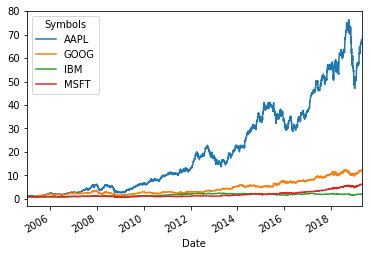

In [4]:
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
from datetime import datetime
%matplotlib inline

logger_file = './'
logger = buildLogger(logger_file, 'CORN')


# load data from Yahoo
yahoo_data = DataReader(['MSFT', 'IBM', 'AAPL', 'GOOG'], 'yahoo', start=datetime(2005,1,1))['Adj Close']
# plot normalized prices of these stocks
(yahoo_data / yahoo_data.iloc[0,:]).plot()
# conpute relative prices
yahoo_data_r = yahoo_data / yahoo_data.shift(1).fillna(method='ffill')
for name, s in yahoo_data_r.iteritems():
    yahoo_data_r[name].iloc[s.index.get_loc(s.first_valid_index()) - 1] = 1.

data = yahoo_data_r[:100].values.T
rho = 0.5
W = 5
wealthRecord, portfolioRecord = CORNU(rho, W, data)


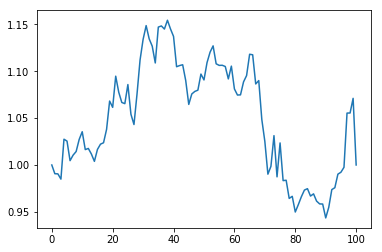

In [4]:
plt.plot(wealthRecord)

**Note**
- combine 可能要改一下，有warning
- 要把cornk的代码加上
- 暂时把画图的代码去了，需要额外加模块
- 记得写preprocessing

## Codes from Github

In [1]:
%matplotlib inline
import pandas as pd
#from universal import tools
from universal import algos
import logging
# we would like to see algos progress
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.DEBUG)

import matplotlib


2019-04-23 01:38:08,905 Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [5]:
# set algo parameters
algo = algos.CORN(window=5, rho=0.5)

# run
result = algo.run(yahoo_data[:100])

2019-04-23 01:39:13,023 Running CORN...
2019-04-23 01:39:13,038 Progress: 0.0%...
2019-04-23 01:39:13,067 Progress: 10.0%...
2019-04-23 01:39:13,109 Progress: 20.0%...
2019-04-23 01:39:13,480 Progress: 30.0%...
2019-04-23 01:39:14,168 Progress: 40.0%...
2019-04-23 01:39:14,718 Progress: 50.0%...
2019-04-23 01:39:15,337 Progress: 60.0%...
2019-04-23 01:39:16,094 Progress: 70.0%...
2019-04-23 01:39:16,868 Progress: 80.0%...
2019-04-23 01:39:17,663 Progress: 90.0%...
2019-04-23 01:39:18,409 CORN finished successfully.


2019-04-23 01:39:26,753 update_title_pos
2019-04-23 01:39:26,786 update_title_pos
2019-04-23 01:39:26,828 update_title_pos
2019-04-23 01:39:26,858 update_title_pos
2019-04-23 01:39:26,904 update_title_pos
2019-04-23 01:39:26,933 update_title_pos
2019-04-23 01:39:26,983 update_title_pos
2019-04-23 01:39:27,011 update_title_pos
2019-04-23 01:39:27,036 update_title_pos
2019-04-23 01:39:27,069 update_title_pos


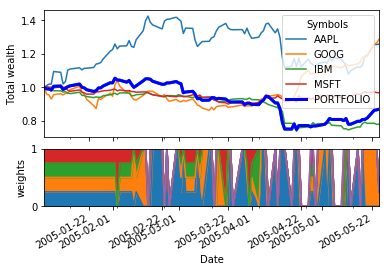

In [6]:
result.plot()

In [7]:
result.weights

Symbols,AAPL,GOOG,IBM,MSFT
Date,,,,
2005-01-03,2.500000e-01,2.500000e-01,2.500000e-01,2.500000e-01
2005-01-04,2.500000e-01,2.500000e-01,2.500000e-01,2.500000e-01
2005-01-05,2.500000e-01,2.500000e-01,2.500000e-01,2.500000e-01
2005-01-06,2.500000e-01,2.500000e-01,2.500000e-01,2.500000e-01
2005-01-07,2.500000e-01,2.500000e-01,2.500000e-01,2.500000e-01
2005-01-10,2.500000e-01,2.500000e-01,2.500000e-01,2.500000e-01
2005-01-11,2.500000e-01,2.500000e-01,2.500000e-01,2.500000e-01
2005-01-12,2.500000e-01,2.500000e-01,2.500000e-01,2.500000e-01
2005-01-13,2.500000e-01,2.500000e-01,2.500000e-01,2.500000e-01


结果跟我们的不一样，因为这个只有一个expert，逻辑是一样的~

它结果打包做得很好